<a href="https://colab.research.google.com/github/CarlosBaez11/Carlos_Baez_C/blob/main/Talleres/MLComp01_Loan_Prediction_Notebook_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loan Prediction Competition

In this workshop, we will apply ensemble methods such as Random Forest and Gradient Boosting to a loan prediction dataset. The dataset used is a modified subset of the **Loan Prediction Problem Dataset** from Kaggle ([link](https://www.kaggle.com/datasets/altruistdelhite04/loan-prediction-problem-dataset)).

## Objective
The task is to predict whether a loan application will be approved based on applicant information.

![Loan Prediction Competition](https://drive.google.com/uc?id=1eipuAdG46mfAgm-KSFth_YEazhJAZHVx)



## Loading the Data

The training dataset is loaded from the **[train.csv](https://drive.google.com/file/d/1Ejs0yaRm3NxFOVIhwQphoDz8voJl6NQx/view?usp=sharing)** file using Pandas. After loading, we inspect the first few rows to understand its structure and check for missing values. Basic preprocessing steps, such as handling null values and encoding categorical variables, will be performed before modeling.


In [96]:
!pip install wandb
!pip install python-dotenv

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, f1_score, accuracy_score, recall_score
from sklearn.model_selection import GridSearchCV
import shap
import wandb
from sklearn.metrics import classification_report

In [18]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Ejs0yaRm3NxFOVIhwQphoDz8voJl6NQx' -O loanpred_train.csv

--2025-03-02 15:11:54--  https://docs.google.com/uc?export=download&id=1Ejs0yaRm3NxFOVIhwQphoDz8voJl6NQx
Resolving docs.google.com (docs.google.com)... 142.250.99.138, 142.250.99.102, 142.250.99.113, ...
Connecting to docs.google.com (docs.google.com)|142.250.99.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1Ejs0yaRm3NxFOVIhwQphoDz8voJl6NQx&export=download [following]
--2025-03-02 15:11:54--  https://drive.usercontent.google.com/download?id=1Ejs0yaRm3NxFOVIhwQphoDz8voJl6NQx&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.188.132, 2607:f8b0:400e:c1b::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.188.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33679 (33K) [application/octet-stream]
Saving to: ‘loanpred_train.csv’

loanpred_train.csv  100%[===================>]  32.89K  --.-KB/s  

In [19]:
# Let's define the "random_state" to ensure reproducible results:
random_state=42

In [20]:
# Let's change the font of Matplotlib plots:
plt.rc('font', family='serif', size=12)

In [21]:
#Let's load the data
# Carguemos los datos:
data = pd.read_csv('loanpred_train.csv')

Vamos a revisar cual es la distribución de datos nulos

In [22]:
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,491.000000,491.000000,471.000000,479.000000,448.000000
mean,5529.997963,1569.537271,147.309979,341.286013,0.850446
std,6457.784318,2789.523475,87.096507,65.855043,0.357032
min,210.000000,0.000000,9.000000,12.000000,0.000000
25%,2906.000000,0.000000,100.000000,360.000000,1.000000
50%,3859.000000,1032.000000,128.000000,360.000000,1.000000
75%,5825.000000,2241.000000,168.000000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


In [23]:
data.isna().sum()

,0
Loan_ID,0
Gender,11
Married,3
Dependents,8
Education,0
Self_Employed,27
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,20
Loan_Amount_Term,12


La varaible que puede presentar más problemas es Credit_History, porque presenta 43 datos nulos.
Empezaremos a realizar la imputación de los datos faltantes utilizando en la medida de lo posible técnicas de estadística robusta para evitar hacer suposiciones acerca de la naturaleza de los datos.

In [24]:
def plot_distributions(data, columns):
  n_cols=len(columns)
  plt.figure(figsize=(n_cols*2, 8))
  for i, column in enumerate(columns):
    plt.subplot(n_cols, 1, i+1)
    sns.histplot(data[column])
    plt.title(column, pad=15)
    plt.title(column)
  plt.tight_layout()

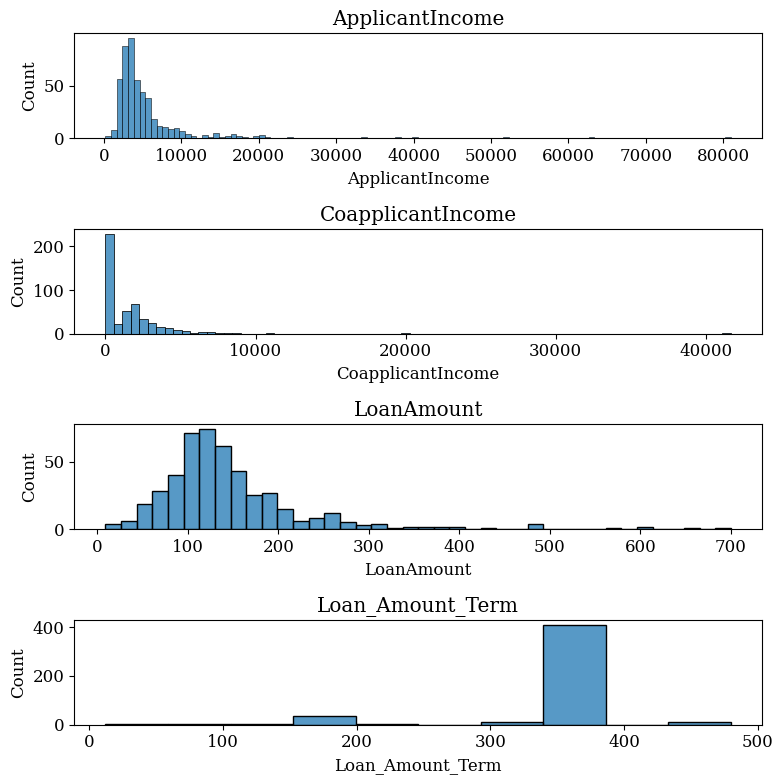

In [25]:
plot_distributions(data, ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'])

## Data Preprocessing Pipeline

Before modeling, we preprocess the dataset by handling missing values, encoding categorical variables, and scaling numerical features if necessary. This ensures that the data is clean and properly formatted for training machine learning models.


Para las variables numéricas tales como 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term' utilizaremos técnicas robustas para hacer menos sensibles los datos a cambios ante la presencia de outliers, por esta razón utilizaremos la media para imputar los datos faltantes

In [ ]:
drop_cols = ['Gender', 'Loan_ID']
numerical_colums=['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
categorical_columns=['Married', 'Education', 'Self_Employed', 'Credit_History','Dependents', 'Property_Area']

In [28]:
def impute_nans_func(X):
    return X.fillna(X.median())  # Usa la mediana de cada columna
# Convertir la función en un transformador válido
impute_nans = FunctionTransformer(impute_nans_func)

def drop_columns(X):
  return X.drop(columns=drop_cols, errors='ignore')
drop_columns = FunctionTransformer(drop_columns)

In [ ]:
preprocessor = ColumnTransformer(transformers=[
                               ('dropped', drop_columns, drop_cols),
                               ('one_hot', OneHotEncoder(), categorical_columns),
                               ('impute_data', impute_nans, numerical_colums)])

# Model Training and Evaluation  

We train machine learning models, such as Random Forest, Gradient Boosting or XGBoost, to predict loan approval. The models are evaluated using appropriate metrics, and hyperparameter tuning is performed to optimize their performance.

In this section, we define the steps for training and evaluating the models.  

## Steps:  
1. **Define the hyperparameters**: Set initial values for model parameters.  
2. **Choose the cross-validation strategy**: Split the dataset into training and validation sets using an appropriate method.  
3. **Train the model**: Fit the model on training data using the defined hyperparameters.  
4. **Evaluate performance**: Use cross-validation to assess the model’s predictive ability.  
5. **Tune hyperparameters (if necessary)**: Optimize parameters for better performance.  

## Hyperparameters  
We define key hyperparameters for Random Forest and Gradient Boosting models, such as:  
- **n_estimators**: Number of trees in the ensemble.  
- **max_depth**: Maximum depth of each tree.  
- **learning_rate** (for boosting models): Controls step size for weight updates.  
- **min_samples_split**: Minimum samples required to split a node.  
- **min_samples_leaf**: Minimum samples required in a leaf node.  

## Cross-Validation Strategy  
To ensure reliable model evaluation, we use **K-Fold Cross-Validation**, which splits the dataset into **K** subsets (folds). The model is trained on **K-1** folds and tested on the remaining fold, repeating the process **K** times. This helps in reducing variance and providing a better generalization estimate.  




In [79]:
X=data.drop('Loan_Status', axis=1)
y=data['Loan_Status']
y = y.map({'Y': 1, 'N': 0})

In [80]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [82]:
preprocessor.fit_transform(x_train, y_train)

array([[1.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 1.560e+02,
        3.600e+02],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 4.983e+03, 3.760e+02,
        3.600e+02],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 0.000e+00, 5.000e+01,
        2.400e+02],
       ...,
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 2.524e+03, 1.280e+02,
        3.600e+02],
       [1.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 1.270e+02,
        3.600e+02],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 4.840e+02, 1.350e+02,
        3.600e+02]])

# Finalizing the Model: Training a Full Pipeline  

Once the best model parameters have been selected, it is essential to **train a complete pipeline** that explicitly separates **data preprocessing** and **model training**. This ensures that preprocessing steps are consistently applied to both training and unseen data.  

## Steps:  
1. **Train the data preprocessing pipeline**:  
   - Handle missing values.  
   - Encode categorical features.  
   - Scale numerical features (if necessary).  

2. **Train the classification pipeline**:  
   - Use the entire processed training dataset and the best model hyperparameters to fit the selected model to make final predictions.  

3. **Save the trained pipelines**:  
   - The preprocessing and classification models should be saved for deployment and inference.  

By structuring the pipeline this way, we maintain consistency between training and real-world predictions while ensuring that preprocessing does not introduce **data leakage**.  


In [89]:
param_grid = {
    'classifier__n_estimators': [1, 2, 3, 5, 10, 20],
    'classifier__max_depth': list(range(1, 10)),
    'classifier__min_samples_leaf': [1, 23, 5, 6, 8, 10, 15]
}

scorers = {
    'f1': make_scorer(f1_score),
    'recall': make_scorer(recall_score),
}

In [90]:
cf_base = RandomForestClassifier(random_state=random_state)

In [91]:
pipeline_rc= Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', cf_base),
                          ])

In [92]:
rc = GridSearchCV(pipeline_rc, cv=3, param_grid=param_grid, scoring=scorers, refit='f1', n_jobs=-1, return_train_score=True)

In [93]:
%%time
# Entrenemos el random forest:
rc.fit(x_train, y_train)

CPU times: user 2.37 s, sys: 120 ms, total: 2.49 s
Wall time: 51.8 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('dropped',
                                                                         FunctionTransformer(func=<function drop_columns at 0x7c4afd3b5800>),
                                                                         ['Gender',
                                                                          'Loan_ID']),
                                                                        ('one_hot',
                                                                         OneHotEncoder(),
                                                                         ['Married',
                                                                          'Education',
                                                                          'Self_Employed',
                                                                          'Credit_History',
                                                                          'Dependents',
                                                                          'Property_Area']),
                                                                        ('impute_data',
                                                                         FunctionTransformer(func=<funct...
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'classifier__min_samples_leaf': [1, 23, 5, 6, 8, 10,
                                                          15],
                         'classifier__n_estimators': [1, 2, 3, 5, 10, 20]},
             refit='f1', return_train_score=True,
             scoring={'f1': make_scorer(f1_score, response_method='predict'),
                      'recall': make_scorer(recall_score, response_method='predict')})

In [101]:
rc.best_params_

{'classifier__max_depth': 2,
 'classifier__min_samples_leaf': 8,
 'classifier__n_estimators': 5,
 'method': 'Random Forest'}

In [104]:
y_pred = rc.best_estimator_.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.46      0.59        28
           1       0.82      0.96      0.88        71

    accuracy                           0.82        99
   macro avg       0.82      0.71      0.74        99
weighted avg       0.82      0.82      0.80        99



# Applying the Pipelines for Prediction  

With the trained **data preprocessing** and **classification pipelines**, we can now apply them to the test dataset to generate predictions.  

## Steps:  
1. **Load the test dataset**: Ensure it has the same structure as the training data.  
2. **Apply the preprocessing pipeline**: Transform the test data using the trained preprocessing steps (e.g., encoding, scaling).  
3. **Make predictions**: Use the trained classification pipeline to predict loan approval outcomes.  
4. **Save or submit predictions**: Store the results for further analysis or competition submission.  

This structured approach ensures consistency and avoids data leakage, making the model reliable for real-world applications.  

In [105]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-03DcqzYIYtIAIt188ujy5Wr4GSdlgv5' -O loanpred_test.csv

--2025-03-02 16:42:36--  https://docs.google.com/uc?export=download&id=1-03DcqzYIYtIAIt188ujy5Wr4GSdlgv5
Resolving docs.google.com (docs.google.com)... 142.250.99.139, 142.250.99.113, 142.250.99.102, ...
Connecting to docs.google.com (docs.google.com)|142.250.99.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1-03DcqzYIYtIAIt188ujy5Wr4GSdlgv5&export=download [following]
--2025-03-02 16:42:36--  https://drive.usercontent.google.com/download?id=1-03DcqzYIYtIAIt188ujy5Wr4GSdlgv5&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.188.132, 2607:f8b0:400e:c1b::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.188.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8358 (8.2K) [application/octet-stream]
Saving to: ‘loanpred_test.csv’

loanpred_test.csv   100%[===================>]   8.16K  --.-KB/s   

In [106]:
#Let's load the test data
test_df = pd.read_csv('loanpred_test.csv')
test_df.head(5)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001528,Male,No,0,Graduate,No,6277,0.0,118.0,360.0,0.0,Rural
1,LP002804,Female,Yes,0,Graduate,No,4180,2306.0,182.0,360.0,1.0,Semiurban
2,LP002945,Male,Yes,0,Graduate,Yes,9963,0.0,180.0,360.0,1.0,Rural
3,LP001784,Male,Yes,1,Graduate,No,5500,1260.0,170.0,360.0,1.0,Rural
4,LP001514,Female,Yes,0,Graduate,No,2330,4486.0,100.0,360.0,1.0,Semiurban


In [107]:
y_pred_test = rc.best_estimator_.predict(test_df)

In [121]:
predictions=pd.DataFrame()
predictions['Loan_ID']=test_df['Loan_ID']
predictions['Loan_Status']=y_pred_test

In [123]:
predictions.to_csv('predictions.csv', index=False)

# Explaining the Model with SHAP  

Understanding how a machine learning model makes predictions is crucial, especially in applications like loan approval, where fairness and transparency are key. **SHAP (SHapley Additive Explanations)** provides a way to interpret the contribution of each feature to a model’s predictions.  

## Why is SHAP Important?  
1. **Improves Trust and Transparency**: Helps explain why a loan was approved or rejected, making the decision process clearer.  
2. **Identifies Key Features**: Highlights which factors influence predictions the most, allowing for better feature selection and model refinement.  
3. **Detects Bias and Unfairness**: Reveals if certain features (e.g., gender, income) have unintended strong effects on decisions.  
4. **Enhances Model Debugging**: Helps diagnose issues like overfitting or unexpected feature dependencies.  

By using SHAP, we ensure that our model is interpretable and aligned with ethical and regulatory standards.  

In [ ]:
# Apply shap to explain

### CODE HERE ###